In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(q):
    with sqlite3.connect(chinook.db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = """SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");"""
    return run_query(q)

show_tables()
    

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


            Genre_Name  total_tracks_sold  percent_of_total
0                 Rock                561          0.533777
1   Alternative & Punk                130          0.123692
2                Metal                124          0.117983
3             R&B/Soul                 53          0.050428
4                Blues                 36          0.034253
5          Alternative                 35          0.033302
6                Latin                 22          0.020932
7                  Pop                 22          0.020932
8          Hip Hop/Rap                 20          0.019029
9                 Jazz                 14          0.013321
10      Easy Listening                 13          0.012369
11              Reggae                  6          0.005709
12   Electronica/Dance                  5          0.004757
13           Classical                  4          0.003806
14         Heavy Metal                  3          0.002854
15          Soundtrack                  

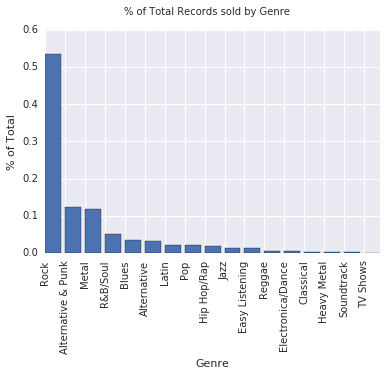

In [2]:
q = """
WITH total_tracks_quantity AS (
SELECT
  SUM(il.quantity) AS total_sold
  FROM invoice_line AS il
  JOIN invoice AS i ON i.invoice_id = il.invoice_id
  WHERE i.billing_country = "USA")

SELECT
  g.name AS Genre_Name,
  SUM(il.quantity) AS total_tracks_sold,
  (CAST(SUM(il.quantity) AS float) / (SELECT CAST(total_sold AS float) FROM total_tracks_quantity AS ttq)) AS percent_of_total


FROM genre AS g
JOIN track AS t ON g.genre_id = t.genre_id
JOIN invoice_line AS il ON t.track_id = il.track_id
JOIN invoice AS i ON il.invoice_id = i.invoice_id

WHERE i.billing_country = "USA"

GROUP BY 1
ORDER BY 3 DESC
"""

run_query(q)

genres_sold = pd.DataFrame(run_query(q))

print(genres_sold)

fig = plt.figure()
n = len(genres_sold["Genre_Name"])
x = range(n)
y = genres_sold["percent_of_total"]
labels = genres_sold["Genre_Name"]
plt.xticks(x, labels, rotation='vertical')
plt.bar(x,y, tick_label = labels)
fig.suptitle("% of Total Records sold by Genre")
plt.xlabel("Genre")
plt.ylabel("% of Total")
plt.show()


## Findings ##

We recommend the three artists due to Rock & Alternative & Punk being the top genres in the US, and R&B/Soul and Blues, and Pop being above Hip-Hop/Rap:

* Red Tone (Punk) - Could appeal to Rock & Alt / Punk fans
* Meteor and the Girls (Pop) - Pop sold slightly more than hip-hop
* Slim Jim Bites - "Blues" is # 5 category and could appeal to R&B / Soul fans as well



   employee_id           name            hire_date  total_sales
0            3   Jane Peacock  2017-04-01 00:00:00      1731.51
1            4  Margaret Park  2017-05-03 00:00:00      1584.00
2            5  Steve Johnson  2017-10-17 00:00:00      1393.92


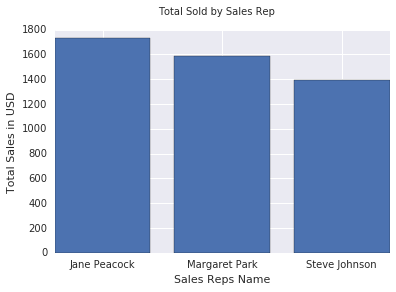

In [3]:
test = """
SELECT title

FROM employee

GROUP BY 1"""

q2 = """
WITH sales_reps AS (
SELECT 
  employee_id,
  first_name || " " || last_name AS name,
  hire_date,
  title,
  country
  
  FROM employee
  
  WHERE title = "Sales Support Agent"
  ),
  
  total_sales_per_rep AS (
  SELECT
  c.support_rep_id AS employee_id,
  SUM(i.total) AS total_sales
  
  FROM customer AS c
  JOIN invoice AS i ON c.customer_id = i.customer_id
  
  GROUP BY 1
  )
  
  SELECT
   r.employee_id AS employee_id,
   r.name AS name,
   r.hire_date AS hire_date,
   s.total_sales AS total_sales
   
  FROM sales_reps AS r
  JOIN total_sales_per_rep AS s ON r.employee_id = s.employee_id
  
  ORDER BY 4 DESC
"""

run_query(q2)

sales_df = pd.DataFrame(run_query(q2))

print(sales_df)

fig = plt.figure()
n = len(sales_df["name"])
x = range(n)
y = sales_df["total_sales"]
labels = sales_df["name"]
plt.xticks(x, labels, rotation='horizontal')
plt.bar(x,y, tick_label = labels, align="center")
fig.suptitle("Total Sold by Sales Rep")
plt.xlabel("Sales Reps Name")
plt.ylabel("Total Sales in USD")
plt.show()


## Finding ##

While it appears that Jane is the most successful sales rep, we should also take into account their hire dates. For example:

* Jane has been at the company since April 2017, ~1 month longer than Margaret and 6 months longer than Steve
* Yet Jane only has several hundred dollars in sales more than Steve
* Assuming it's Dec 31, 2017, then that means per month sales rates are:
  * Jane: \$1731.51 / 9 months since hire = \$192.39 / month
  * Margaret: \$1584 / 9 months since hire = \$176 / month
  * Steve: \$1393.92 / 2.5 months since hire = \$557.56 /month
  
Looking at in this way, it appears Steve is the most productive salesperson on a monthly basis


In [4]:
q3 = """
WITH country_customers AS (
SELECT 
  country AS country,
  COUNT(DISTINCT(c.customer_id)) AS Number_of_Customers,
  SUM(i.total) AS Total_Sales,
  AVG(i.total) AS Average_Order_Value
  
FROM customer AS c
LEFT JOIN invoice AS i ON i.customer_id = c.customer_id


GROUP BY 1

ORDER BY 2 ASC
),

  country_counts AS (

SELECT
  CASE WHEN 
    sub.Number_of_Customers = 1 THEN "Other"
    ELSE sub.Country END AS Country,
  SUM(sub.Number_of_Customers) AS Number_of_Customers,
  (SUM(sub.Total_Sales_Value) * sub.Number_of_Customers) AS Total_Sales,
  AVG(sub.Average_Sales_Value) AS Average_Total_Sales,
  Average_Order_Value AS Average_Order_Value

FROM
(
SELECT
  cc.country AS Country,
  SUM(cc.Number_of_Customers) AS Number_of_Customers,
  SUM(Total_Sales) AS Total_Sales_Value,
  AVG(Total_Sales) AS Average_Sales_Value,
  Average_Order_Value AS Average_Order_Value

FROM country_customers AS cc

GROUP BY 1
) sub

GROUP BY 1

)

SELECT
  Country,
  Number_of_Customers AS Total_Number_of_Customers,
  Total_Sales,
  Average_Total_Sales AS Average_Value_of_Sales_Per_Customer,
  Average_Order_Value AS Average_Order_Value
  
  
FROM (
SELECT
  sorted_cc.*,
  CASE WHEN sorted_cc.Country = "Other" THEN 1
  ELSE 0 END AS sort
  
  FROM country_counts AS sorted_cc
  
  ORDER BY Number_of_Customers DESC
)


ORDER BY sort ASC



"""

run_query(q3)

,Country,Total_Number_of_Customers,Total_Sales,Average_Value_of_Sales_Per_Customer,Average_Order_Value
0,USA,13,13526.37,1040.490,7.942672
1,Canada,8,4284.72,535.590,7.047237
2,Brazil,5,2138.40,427.680,7.011148
3,France,5,1945.35,389.070,7.781400
4,Germany,4,1338.48,334.620,8.161463
5,United Kingdom,3,736.56,245.520,8.768571
6,Czech Republic,2,546.48,273.240,9.108000
7,India,2,366.30,183.150,8.721429
8,Portugal,2,370.26,185.130,6.383793
9,Other,15,1094.94,72.996,7.524000


          Country  Total_Number_of_Customers  Total_Sales  \
0             USA                         13     13526.37   
1          Canada                          8      4284.72   
2          Brazil                          5      2138.40   
3          France                          5      1945.35   
4         Germany                          4      1338.48   
5  United Kingdom                          3       736.56   
6  Czech Republic                          2       546.48   
7           India                          2       366.30   
8        Portugal                          2       370.26   
9           Other                         15      1094.94   

   Average_Value_of_Sales_Per_Customer  Average_Order_Value  
0                             1040.490             7.942672  
1                              535.590             7.047237  
2                              427.680             7.011148  
3                              389.070             7.781400  
4                 

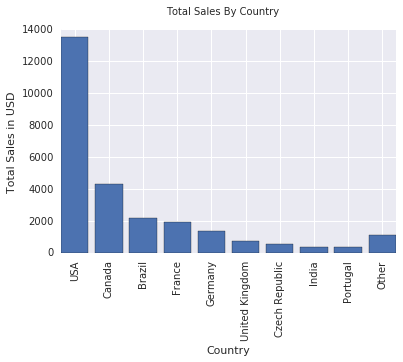

In [5]:
country_df = pd.DataFrame(run_query(q3))

print(country_df)

fig = plt.figure()
n = len(country_df["Country"])
x = range(n)
y = country_df["Total_Sales"]
labels = country_df["Country"]
plt.xticks(x, labels, rotation='vertical')
plt.bar(x,y, tick_label = labels, align="center")
fig.suptitle("Total Sales By Country")
plt.xlabel("Country")
plt.ylabel("Total Sales in USD")
plt.show()


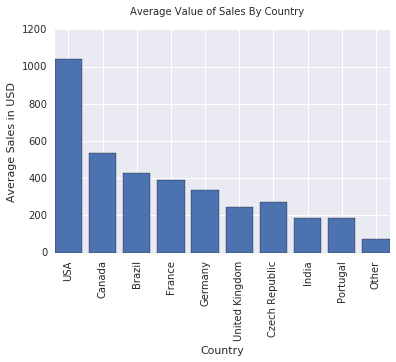

In [6]:
fig = plt.figure()
n = len(country_df["Country"])
x = range(n)
y = country_df["Average_Value_of_Sales_Per_Customer"]
labels = country_df["Country"]
plt.xticks(x, labels, rotation='vertical')
plt.bar(x,y, tick_label = labels, align="center")
fig.suptitle("Average Value of Sales By Country")
plt.xlabel("Country")
plt.ylabel("Average Sales in USD")
plt.show()


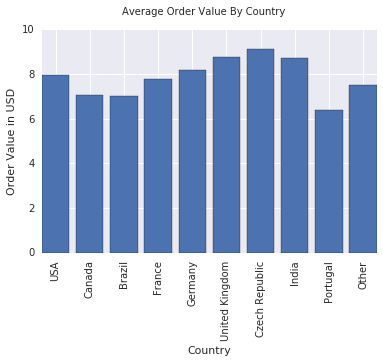

In [7]:
fig = plt.figure()
n = len(country_df["Country"])
x = range(n)
y = country_df["Average_Order_Value"]
labels = country_df["Country"]
plt.xticks(x, labels, rotation='vertical')
plt.bar(x,y, tick_label = labels, align="center")
fig.suptitle("Average Order Value By Country")
plt.xlabel("Country")
plt.ylabel("Order Value in USD")
plt.show()

## Findings ##

While the USA is by far the leader in total sales and average value of sales by country, we can deduce from the average order value above that:

* The United Kingdom, Czech Republic and India have the highest average order value
* These three countries are likely high-growth countries, given that they're on the lower-end of the total sales volume spectrum

In [26]:
q4 = """
WITH invoice_first_track AS (
SELECT
  il.invoice_id AS invoice_id,
  MIN(il.track_id) AS first_track_id
  
  FROM invoice_line AS il
  
  GROUP BY 1
)


SELECT
  album_purchase AS Album_Purchase,
  COUNT(invoice_id) Number_of_Invoices,
  CAST(count(invoice_id) AS FLOAT) / ( SELECT COUNT(*) 
                                       FROM invoice
                                      ) AS Percent_of_Total
FROM 
(
  SELECT ifs.*,
  CASE WHEN
    (SELECT t.track_id 
     FROM track AS t
     WHERE t.album_id = (SELECT t2.album_id
                        FROM track AS t2
                        WHERE t2.track_id = ifs.first_track_id
                        )
     
     
     
     EXCEPT
     
     SELECT il2.track_id 
            FROM invoice_line AS il2
            WHERE il2.invoice_id = ifs.invoice_id
            
    ) IS NULL
    
    AND
    
    (SELECT il2.track_id 
            FROM invoice_line AS il2
            WHERE il2.invoice_id = ifs.invoice_id
    
    EXCEPT
    
    SELECT t.track_id 
     FROM track AS t
     WHERE t.album_id = (SELECT t2.album_id
                        FROM track AS t2
                        WHERE t2.track_id = ifs.first_track_id
                        )
    
    ) IS NULL
    
    THEN "Album Purchase"
    ELSE "Non-Album Purchase" END AS album_purchase

FROM invoice_first_track AS ifs
)
GROUP BY 1
"""

run_query(q4)

,Album_Purchase,Number_of_Invoices,Percent_of_Total
0,Album Purchase,114,0.185668
1,Non-Album Purchase,500,0.814332
